# Importing Libraries

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torchvision.datasets as datasets
import tqdm

# Loading Datasets

In [34]:
disease_types=['COVID', 'non-COVID']
data_dir = "data/SARS-Cov-2-Ct-Scan-Dataset/"

In [35]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor(),           # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image
])
dataset = datasets.ImageFolder(data_dir, transform=transform)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


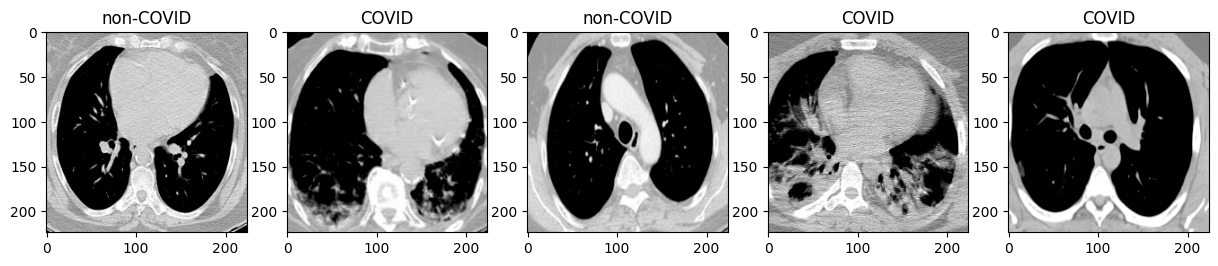

In [36]:
get_label_name = {v: k for k, v in dataset.class_to_idx.items()}
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
random_indices = list(np.random.randint(0, len(dataset), 5))
for i, idx in enumerate(random_indices):
    img, label = dataset[idx]
    ax[i].imshow(img.permute(1, 2, 0))
    ax[i].set_title(get_label_name[label])

# Device Configuration

In [37]:
device = torch.device('cuda ' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Defining Hyperparameters

In [69]:
EPOCH = 50
BATCH_SIZE = 128
LEARNING_RATE = 0.001

# Splitting Dataset into Train and Test Sets

In [70]:
# Split the data into train and test sets 80/20
split = 0.8
train_size = int(split * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

print(f"Train size: {len(train_set)}")
print(f"Test size: {len(test_set)}")

Train size: 1984
Test size: 497


# Load the data using DataLoader

In [71]:
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Define CNN Architecture

In [72]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1) # 224x224x3 -> 224x224x16
    self.relu1 = nn.ReLU()
    self.maxpool1 = nn.MaxPool2d(kernel_size=2) # 224x224x16 -> 112x112x16

    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1) # 112x112x16 -> 112x112x32
    self.relu2 = nn.ReLU()
    self.maxpool2 = nn.MaxPool2d(kernel_size=2) # 112x112x32 -> 56x56x32

    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) # 56x56x32 -> 56x56x64
    self.relu3 = nn.ReLU()
    self.maxpool3 = nn.MaxPool2d(kernel_size=2) # 56x56x64 -> 28x28x64

    self.fc1 = nn.Linear(in_features=28*28*64, out_features=500) # 28x28x64 = 50176 -> 500
    self.relu4 = nn.ReLU() 
    self.fc2 = nn.Linear(in_features=500, out_features=2) # 500 -> 2


  def forward(self, x):
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.maxpool1(x)

    x = self.conv2(x)
    x = self.relu2(x)
    x = self.maxpool2(x)

    x = self.conv3(x)
    x = self.relu3(x)
    x = self.maxpool3(x)

    x = x.view(-1, 28*28*64)
    x = self.fc1(x)
    x = self.relu4(x)
    x = self.fc2(x)
    return x

# Defining Loss, Optimizer and Model

In [73]:
model = CNN().to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Model Training and Evaluation

In [74]:
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

def train(model, optimizer, loss_fn, trainloader, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm.tqdm(trainloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss_value = loss_fn(outputs, labels)
        loss_value.backward()
        optimizer.step()

        running_loss += loss_value.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(running_loss / len(trainloader))
    train_accuracy.append(correct / total)
    print(f"Training | Loss: {running_loss / len(trainloader)} | Accuracy: {(correct / total) * 100}")

def test(model, loss_fn, testloader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm.tqdm(testloader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss_value = loss_fn(outputs, labels)

            running_loss += loss_value.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss.append(running_loss / len(testloader))
    test_accuracy.append(correct / total)
    print(f"Testing | Loss: {running_loss / len(testloader)} | Accuracy: {(correct / total) * 100}")

# Training loop
for epoch in range(EPOCH):
    print(f"EPOCH {epoch + 1}")
    train(model, optimizer, loss, trainloader, device)
    test(model, loss, testloader, device)

EPOCH 1


Training: 100%|██████████| 16/16 [01:32<00:00,  5.77s/it]


Training | Loss: 0.9564191177487373 | Accuracy: 53.07459677419355


Testing: 100%|██████████| 4/4 [00:09<00:00,  2.34s/it]


Testing | Loss: 0.6425940543413162 | Accuracy: 56.74044265593562
EPOCH 2


Training: 100%|██████████| 16/16 [01:27<00:00,  5.46s/it]


Training | Loss: 0.542233744636178 | Accuracy: 73.73991935483872


Testing: 100%|██████████| 4/4 [00:09<00:00,  2.34s/it]


Testing | Loss: 0.44662051647901535 | Accuracy: 79.87927565392354
EPOCH 3


Training: 100%|██████████| 16/16 [01:27<00:00,  5.47s/it]


Training | Loss: 0.38672703690826893 | Accuracy: 84.57661290322581


Testing: 100%|██████████| 4/4 [00:09<00:00,  2.34s/it]


Testing | Loss: 0.338733933866024 | Accuracy: 85.3118712273642
EPOCH 4


Training: 100%|██████████| 16/16 [01:27<00:00,  5.47s/it]


Training | Loss: 0.30329697392880917 | Accuracy: 88.00403225806451


Testing: 100%|██████████| 4/4 [00:09<00:00,  2.35s/it]


Testing | Loss: 0.3463168665766716 | Accuracy: 83.09859154929578
EPOCH 5


Training: 100%|██████████| 16/16 [01:27<00:00,  5.47s/it]


Training | Loss: 0.2582653136923909 | Accuracy: 89.91935483870968


Testing: 100%|██████████| 4/4 [00:09<00:00,  2.35s/it]


Testing | Loss: 0.23831813037395477 | Accuracy: 90.74446680080483
EPOCH 6


Training: 100%|██████████| 16/16 [01:27<00:00,  5.47s/it]


Training | Loss: 0.20334505569189787 | Accuracy: 92.1875


Testing: 100%|██████████| 4/4 [00:09<00:00,  2.35s/it]


Testing | Loss: 0.196538046002388 | Accuracy: 91.75050301810866
EPOCH 7


Training: 100%|██████████| 16/16 [01:31<00:00,  5.73s/it]


Training | Loss: 0.17110395897179842 | Accuracy: 93.34677419354838


Testing: 100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


Testing | Loss: 0.17642049863934517 | Accuracy: 93.96378269617706
EPOCH 8


Training: 100%|██████████| 16/16 [01:28<00:00,  5.50s/it]


Training | Loss: 0.13983561703935266 | Accuracy: 94.40524193548387


Testing: 100%|██████████| 4/4 [00:09<00:00,  2.36s/it]


Testing | Loss: 0.23150040581822395 | Accuracy: 89.93963782696177
EPOCH 9


Training: 100%|██████████| 16/16 [01:28<00:00,  5.51s/it]


Training | Loss: 0.13522872887551785 | Accuracy: 94.40524193548387


Testing: 100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


Testing | Loss: 0.16808054968714714 | Accuracy: 93.56136820925553
EPOCH 10


Training: 100%|██████████| 16/16 [01:28<00:00,  5.51s/it]


Training | Loss: 0.09284243220463395 | Accuracy: 96.06854838709677


Testing: 100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


Testing | Loss: 0.2567232623696327 | Accuracy: 89.33601609657947
EPOCH 11


Training: 100%|██████████| 16/16 [01:28<00:00,  5.52s/it]


Training | Loss: 0.07873636251315475 | Accuracy: 97.22782258064517


Testing: 100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


Testing | Loss: 0.1572949793189764 | Accuracy: 93.96378269617706
EPOCH 12


Training: 100%|██████████| 16/16 [01:28<00:00,  5.52s/it]


Training | Loss: 0.05246190563775599 | Accuracy: 98.13508064516128


Testing: 100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


Testing | Loss: 0.13228721916675568 | Accuracy: 95.37223340040242
EPOCH 13


Training: 100%|██████████| 16/16 [01:28<00:00,  5.54s/it]


Training | Loss: 0.028770150966010988 | Accuracy: 99.04233870967742


Testing: 100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


Testing | Loss: 0.16676560044288635 | Accuracy: 94.76861167002012
EPOCH 14


Training: 100%|██████████| 16/16 [01:28<00:00,  5.55s/it]


Training | Loss: 0.019074913958320394 | Accuracy: 99.74798387096774


Testing: 100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


Testing | Loss: 0.15935679152607918 | Accuracy: 94.96981891348088
EPOCH 15


Training: 100%|██████████| 16/16 [01:28<00:00,  5.55s/it]


Training | Loss: 0.014116717618890107 | Accuracy: 99.84879032258065


Testing: 100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


Testing | Loss: 0.14936560951173306 | Accuracy: 95.17102615694165
EPOCH 16


Training: 100%|██████████| 16/16 [01:33<00:00,  5.83s/it]


Training | Loss: 0.006834938860265538 | Accuracy: 99.94959677419355


Testing: 100%|██████████| 4/4 [00:10<00:00,  2.54s/it]


Testing | Loss: 0.15427251532673836 | Accuracy: 95.37223340040242
EPOCH 17


Training: 100%|██████████| 16/16 [01:31<00:00,  5.69s/it]


Training | Loss: 0.0032585197186563164 | Accuracy: 100.0


Testing: 100%|██████████| 4/4 [00:09<00:00,  2.46s/it]


Testing | Loss: 0.15012501552700996 | Accuracy: 95.37223340040242
EPOCH 18


Training: 100%|██████████| 16/16 [01:33<00:00,  5.87s/it]


Training | Loss: 0.0019816931962850504 | Accuracy: 100.0


Testing: 100%|██████████| 4/4 [00:11<00:00,  2.80s/it]


Testing | Loss: 0.1704540103673935 | Accuracy: 95.57344064386318
EPOCH 19


Training: 100%|██████████| 16/16 [01:36<00:00,  6.02s/it]


Training | Loss: 0.0012583125790115446 | Accuracy: 100.0


Testing: 100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


Testing | Loss: 0.1723590586334467 | Accuracy: 95.97585513078471
EPOCH 20


Training: 100%|██████████| 16/16 [01:34<00:00,  5.92s/it]


Training | Loss: 0.0009411020073457621 | Accuracy: 100.0


Testing: 100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


Testing | Loss: 0.16124102473258972 | Accuracy: 96.37826961770624
EPOCH 21


Training: 100%|██████████| 16/16 [01:34<00:00,  5.94s/it]


Training | Loss: 0.0008353354078280972 | Accuracy: 100.0


Testing: 100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Testing | Loss: 0.16913589276373386 | Accuracy: 96.37826961770624
EPOCH 22


Training: 100%|██████████| 16/16 [01:34<00:00,  5.91s/it]


Training | Loss: 0.0005878717347513884 | Accuracy: 100.0


Testing: 100%|██████████| 4/4 [00:10<00:00,  2.61s/it]


Testing | Loss: 0.17662188410758972 | Accuracy: 95.77464788732394
EPOCH 23


Training: 100%|██████████| 16/16 [01:37<00:00,  6.11s/it]


Training | Loss: 0.0005171245356905274 | Accuracy: 100.0


Testing: 100%|██████████| 4/4 [00:10<00:00,  2.72s/it]


Testing | Loss: 0.18814137764275074 | Accuracy: 95.57344064386318
EPOCH 24


Training: 100%|██████████| 16/16 [01:49<00:00,  6.83s/it]


Training | Loss: 0.0004461380285647465 | Accuracy: 100.0


Testing: 100%|██████████| 4/4 [00:13<00:00,  3.30s/it]


Testing | Loss: 0.1958877071738243 | Accuracy: 95.57344064386318
EPOCH 25


Training: 100%|██████████| 16/16 [01:43<00:00,  6.48s/it]


Training | Loss: 0.00035482262956065824 | Accuracy: 100.0


Testing: 100%|██████████| 4/4 [00:12<00:00,  3.24s/it]


Testing | Loss: 0.19886734709143639 | Accuracy: 95.57344064386318
EPOCH 26


Training: 100%|██████████| 16/16 [01:43<00:00,  6.50s/it]


Training | Loss: 0.0003140820554108359 | Accuracy: 100.0


Testing: 100%|██████████| 4/4 [00:11<00:00,  2.85s/it]


Testing | Loss: 0.19532867334783077 | Accuracy: 95.57344064386318
EPOCH 27


Training: 100%|██████████| 16/16 [01:55<00:00,  7.21s/it]


Training | Loss: 0.00027481915640237276 | Accuracy: 100.0


Testing: 100%|██████████| 4/4 [00:12<00:00,  3.23s/it]


Testing | Loss: 0.18348371051251888 | Accuracy: 95.77464788732394
EPOCH 28


Training: 100%|██████████| 16/16 [01:45<00:00,  6.59s/it]


Training | Loss: 0.00024408567605860298 | Accuracy: 100.0


Testing: 100%|██████████| 4/4 [00:15<00:00,  3.89s/it]


Testing | Loss: 0.18873591162264347 | Accuracy: 95.97585513078471
EPOCH 29


Training: 100%|██████████| 16/16 [01:56<00:00,  7.29s/it]


Training | Loss: 0.00021002053426855127 | Accuracy: 100.0


Testing: 100%|██████████| 4/4 [00:11<00:00,  2.85s/it]


Testing | Loss: 0.19335808232426643 | Accuracy: 95.77464788732394
EPOCH 30


Training: 100%|██████████| 16/16 [01:42<00:00,  6.40s/it]


Training | Loss: 0.00018196249948232435 | Accuracy: 100.0


Testing: 100%|██████████| 4/4 [00:11<00:00,  2.93s/it]


Testing | Loss: 0.1978993508964777 | Accuracy: 95.77464788732394
EPOCH 31


Training: 100%|██████████| 16/16 [01:42<00:00,  6.39s/it]


Training | Loss: 0.0001630205224500969 | Accuracy: 100.0


Testing: 100%|██████████| 4/4 [00:11<00:00,  2.88s/it]


Testing | Loss: 0.19765583612024784 | Accuracy: 95.97585513078471
EPOCH 32


Training: 100%|██████████| 16/16 [01:41<00:00,  6.36s/it]


Training | Loss: 0.00014316783426693291 | Accuracy: 100.0


Testing: 100%|██████████| 4/4 [00:11<00:00,  2.82s/it]


Testing | Loss: 0.2039688564836979 | Accuracy: 95.77464788732394
EPOCH 33


Training: 100%|██████████| 16/16 [01:41<00:00,  6.33s/it]


Training | Loss: 0.00013012586214244948 | Accuracy: 100.0


Testing: 100%|██████████| 4/4 [00:11<00:00,  2.81s/it]


Testing | Loss: 0.1998470313847065 | Accuracy: 95.97585513078471
EPOCH 34


Training: 100%|██████████| 16/16 [01:40<00:00,  6.29s/it]


Training | Loss: 0.00011846938059534295 | Accuracy: 100.0


Testing: 100%|██████████| 4/4 [00:11<00:00,  2.82s/it]


Testing | Loss: 0.20456933975219727 | Accuracy: 95.77464788732394
EPOCH 35


Training: 100%|██████████| 16/16 [01:40<00:00,  6.30s/it]


Training | Loss: 0.00010874683039219235 | Accuracy: 100.0


Testing: 100%|██████████| 4/4 [00:11<00:00,  2.82s/it]


Testing | Loss: 0.20239418372511864 | Accuracy: 95.97585513078471
EPOCH 36


Training: 100%|██████████| 16/16 [01:41<00:00,  6.32s/it]


Training | Loss: 9.885203553494648e-05 | Accuracy: 100.0


Testing: 100%|██████████| 4/4 [00:11<00:00,  2.79s/it]


Testing | Loss: 0.20328054390847683 | Accuracy: 95.97585513078471
EPOCH 37


Training: 100%|██████████| 16/16 [01:38<00:00,  6.16s/it]


Training | Loss: 9.4159340733313e-05 | Accuracy: 100.0


Testing: 100%|██████████| 4/4 [00:10<00:00,  2.69s/it]


Testing | Loss: 0.20170182548463345 | Accuracy: 95.77464788732394
EPOCH 38


Training: 100%|██████████| 16/16 [01:36<00:00,  6.04s/it]


Training | Loss: 8.43969448851567e-05 | Accuracy: 100.0


Testing: 100%|██████████| 4/4 [00:10<00:00,  2.65s/it]


Testing | Loss: 0.2087321151047945 | Accuracy: 95.97585513078471
EPOCH 39


Training: 100%|██████████| 16/16 [01:36<00:00,  6.01s/it]


Training | Loss: 7.921659607745823e-05 | Accuracy: 100.0


Testing: 100%|██████████| 4/4 [00:10<00:00,  2.67s/it]


Testing | Loss: 0.2068952713161707 | Accuracy: 95.97585513078471
EPOCH 40


Training: 100%|██████████| 16/16 [01:35<00:00,  5.97s/it]


Training | Loss: 7.168343745433958e-05 | Accuracy: 100.0


Testing: 100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


Testing | Loss: 0.2099121119827032 | Accuracy: 95.97585513078471
EPOCH 41


Training: 100%|██████████| 16/16 [01:35<00:00,  5.96s/it]


Training | Loss: 6.73068429932755e-05 | Accuracy: 100.0


Testing: 100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


Testing | Loss: 0.20816558972001076 | Accuracy: 95.97585513078471
EPOCH 42


Training: 100%|██████████| 16/16 [01:35<00:00,  6.00s/it]


Training | Loss: 6.31236389381229e-05 | Accuracy: 100.0


Testing: 100%|██████████| 4/4 [00:10<00:00,  2.67s/it]


Testing | Loss: 0.20797636546194553 | Accuracy: 95.77464788732394
EPOCH 43


Training: 100%|██████████| 16/16 [01:35<00:00,  5.98s/it]


Training | Loss: 5.988818168134458e-05 | Accuracy: 100.0


Testing: 100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


Testing | Loss: 0.2145658526569605 | Accuracy: 95.97585513078471
EPOCH 44


Training: 100%|██████████| 16/16 [01:35<00:00,  5.96s/it]


Training | Loss: 5.475445618685626e-05 | Accuracy: 100.0


Testing: 100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


Testing | Loss: 0.21123558655381203 | Accuracy: 95.97585513078471
EPOCH 45


Training: 100%|██████████| 16/16 [01:35<00:00,  5.95s/it]


Training | Loss: 5.191677792026894e-05 | Accuracy: 100.0


Testing: 100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


Testing | Loss: 0.21426707692444324 | Accuracy: 95.97585513078471
EPOCH 46


Training: 100%|██████████| 16/16 [01:35<00:00,  5.97s/it]


Training | Loss: 4.83856790651771e-05 | Accuracy: 100.0


Testing: 100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


Testing | Loss: 0.21698930859565735 | Accuracy: 95.97585513078471
EPOCH 47


Training: 100%|██████████| 16/16 [01:35<00:00,  5.99s/it]


Training | Loss: 4.654906456380559e-05 | Accuracy: 100.0


Testing: 100%|██████████| 4/4 [00:10<00:00,  2.67s/it]


Testing | Loss: 0.21418186090886593 | Accuracy: 95.97585513078471
EPOCH 48


Training: 100%|██████████| 16/16 [01:35<00:00,  5.98s/it]


Training | Loss: 4.429926582361077e-05 | Accuracy: 100.0


Testing: 100%|██████████| 4/4 [00:10<00:00,  2.67s/it]


Testing | Loss: 0.21560692973434925 | Accuracy: 95.97585513078471
EPOCH 49


Training: 100%|██████████| 16/16 [01:35<00:00,  5.94s/it]


Training | Loss: 3.997708256520127e-05 | Accuracy: 100.0


Testing: 100%|██████████| 4/4 [00:10<00:00,  2.67s/it]


Testing | Loss: 0.219293974339962 | Accuracy: 95.97585513078471
EPOCH 50


Training: 100%|██████████| 16/16 [01:35<00:00,  5.95s/it]


Training | Loss: 3.779388237035164e-05 | Accuracy: 100.0


Testing: 100%|██████████| 4/4 [00:10<00:00,  2.65s/it]

Testing | Loss: 0.21540892869234085 | Accuracy: 95.97585513078471


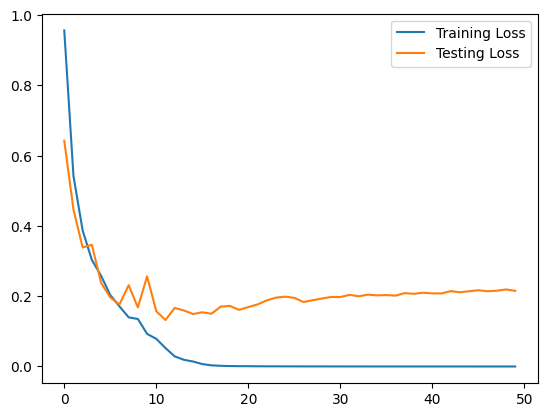

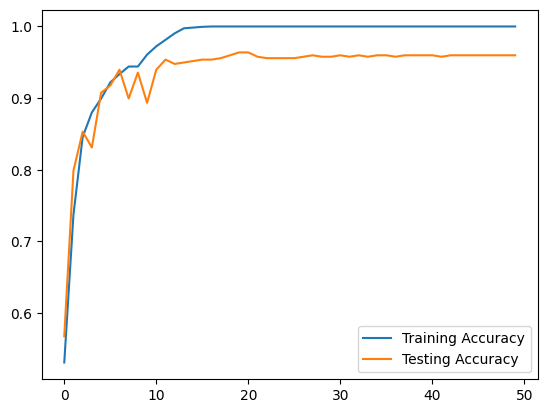

In [75]:
#Plotting Loss and Accuracy

plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.legend()
plt.show()

plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


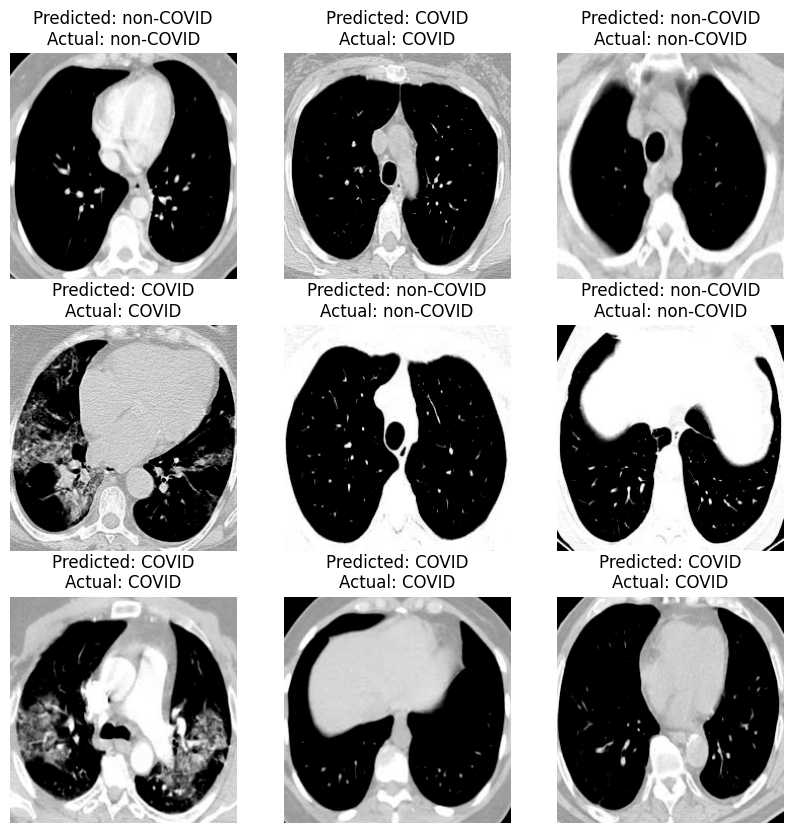

In [91]:
# Plot first 9 predictions vs actual

fig, ax = plt.subplots(3, 3, figsize=(10, 10))
random_indices = np.random.choice(range(len(test_set)), size=9, replace=False)
for i, idx in enumerate(random_indices):
    img, label = test_set[idx]
    img = img.unsqueeze(0)
    label = label
    output = model(img)
    _, predicted = torch.max(output.data, 1)
    predicted = predicted.item()
    ax[i//3, i%3].imshow(img.squeeze(0).permute(1, 2, 0).cpu())
    ax[i//3, i%3].set_title(f"Predicted: {get_label_name[predicted]}\nActual: {get_label_name[label]}")
    ax[i//3, i%3].axis('off')
plt.show()